In [69]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

In [70]:
datos = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/datos_igrf_2015.dat", delimiter=" ",
                      usecols=(1, 2, 3, 4, 5, 6)).T

thetav = numpy.deg2rad(90 - datos[0])
phiv = numpy.deg2rad(datos[1])

Bx, By, Bz = datos[3:]

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 45.0))

In [71]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

Bx_r = numpy.empty_like(Bx); By_r = numpy.empty_like(By); Bz_r = numpy.empty_like(Bz)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx,By,Bz,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

In [72]:
ms = numpy.arange(0, 8);
roots = scha.degree(ms, theta0 = theta_0, max_k = 7)
k, m, n = scha.join_roots(roots)

In [73]:
importlib.reload(scha)
gp=scha.invert_xyz(theta_r, phi_r, Bx_r, By_r, Bz_r, (k, m, n))
Bx_inv, By_inv, Bz_inv = scha.xyzfield(k, m, n, gp, theta_r, phi_r)

In [74]:
print("{:>10}{:>10}        {:>12}        {:>11}        {:>11}".format("k", "m", "n(k,m)", "g(k,m)", "K(n,m)"))
print("----------------------------------------------------------------------------------------")

for ki, mi, ni, gi, si in zip(k, m, n, gp, scha.schmidt_real(m, n, grid=False)):
    print("{:>10}{:>10}        {:12.7f}        {:+11.6e}        {:+11.6e}".format(ki, mi, ni, gi, si))

         k         m              n(k,m)             g(k,m)             K(n,m)
----------------------------------------------------------------------------------------
         0         0           0.0000000        -1.143459e+04        +1.000000e+00
         1         0           2.5478992        -2.111213e+04        +1.000000e+00
         1         1           2.0000000        +3.333394e+04        -5.773503e-01
         1        -1           2.0000000        +3.661690e+03        -5.773503e-01
         2         0           4.4053292        +1.825968e+04        +1.000000e+00
         2         1           4.4053292        -3.397401e+04        -2.898109e-01
         2        -1           4.4053292        -8.479477e+03        -2.898109e-01
         2         2           3.6332387        +1.187855e+03        +8.949556e-02
         2        -2           3.6332387        +7.745198e+02        +8.949556e-02
         3         0           6.5222103        -1.457597e+04        +1.000000e+00
  

In [75]:
k_maxes = numpy.arange(1, 6)
rms = numpy.empty_like(k_maxes)
for j, k_max in enumerate(k_maxes):
    ms = numpy.arange(0, k_max+1)
    k, m, n = scha.join_roots(scha.degree(ms, theta_0, k_max, overstep_size=0.01))
    gp=scha.invert_xyz(theta_r, phi_r, Bx_r, By_r, Bz_r, (k, m, n))
    #gp=gp_javi[:(k_max+1)**2]
    Bx_k, By_k, Bz_k = scha.xyzfield(k, m, n, gp, theta_r, phi_r)
    
    Bx_rr = numpy.empty_like(Bx); By_rr = numpy.empty_like(By); Bz_rr = numpy.empty_like(Bz)
    Bx_or = numpy.empty_like(Bx); By_or = numpy.empty_like(By); Bz_or = numpy.empty_like(Bz)
    for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_k,By_k,Bz_k,thetav,phiv,theta_r)):
        Bx_rr[i], By_rr[i], Bz_rr[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                          th_i, phi_i, th_ri, invert=True)
    for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_r,By_r,Bz_r,thetav,phiv,theta_r)):
        Bx_or[i], By_or[i], Bz_or[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                          th_i, phi_i, th_ri, invert=True)
        
    rms[j] = numpy.sqrt(numpy.sum(numpy.concatenate((Bx-Bx_rr, By-By_rr, Bz-Bz_rr))**2)/(len(Bx)*3))

<IPython.core.display.Javascript object>


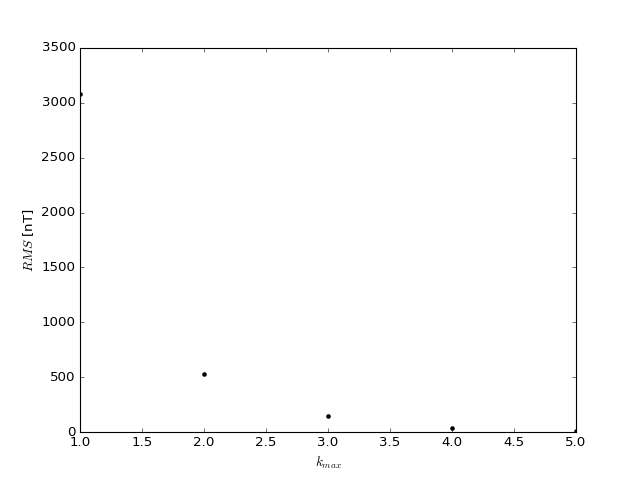

In [76]:
fig, ax1 = pyplot.subplots()

ax1.plot(k_maxes, rms, "ko", markersize=3.5)
ax1.set_ylabel("$RMS$ [nT]")
ax1.set_xlabel("$k_{max}$")

pyplot.show(fig)

<IPython.core.display.Javascript object>


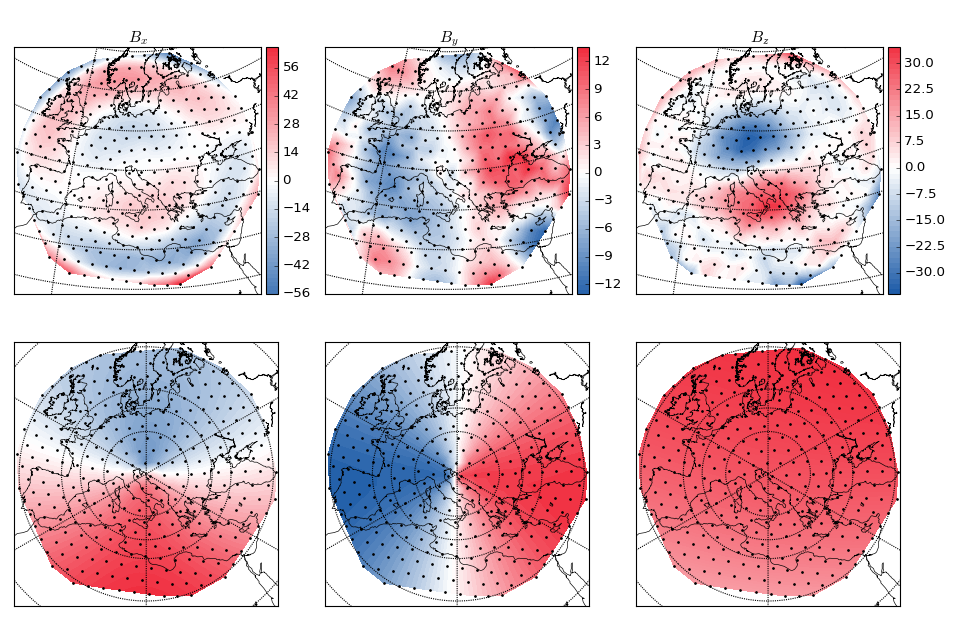

In [77]:
fig, axes = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = 15.0, lat_0=45.0, lat_ts=45.0,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)
base.colorbar(scha.polar_tricontour(Bx_r-Bx_k, theta_r, phi_r, theta_0, ax=axes[0][0], base=base, cmap=nicebwr),ax=axes[0][0])
base.colorbar(scha.polar_tricontour(By_r-By_k, theta_r, phi_r, theta_0, ax=axes[0][1], base=base, cmap=nicebwr),ax=axes[0][1])
base.colorbar(scha.polar_tricontour(Bz_r-Bz_k, theta_r, phi_r, theta_0, ax=axes[0][2], base=base, cmap=nicebwr),ax=axes[0][2])

axes[0][0].set_title("$B_{x}$")
axes[0][1].set_title("$B_{y}$")
axes[0][2].set_title("$B_{z}$")

scha.polar_tricontour(Bx_k, theta_r, phi_r, theta_0, ax=axes[1][0], base=base, cmap=nicebwr)
scha.polar_tricontour(By_k, theta_r, phi_r, theta_0, ax=axes[1][1], base=base, cmap=nicebwr)
scha.polar_tricontour(Bz_k, theta_r, phi_r, theta_0, ax=axes[1][2], base=base, cmap=nicebwr)

for ax in axes[0]:
    base2.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base2.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
for ax in axes[1]:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

fig.tight_layout()
pyplot.show(fig)

In [20]:
importlib.reload(scha)
D = numpy.zeros_like(thetav)

In [31]:
D_r = scha.rotate_declination(D, theta_c, phi_c, thetav, phiv, theta_r)
D_rr = scha.rotate_declination(D_r, theta_c, phi_c, thetav, phiv, theta_r, invert=True)

<IPython.core.display.Javascript object>


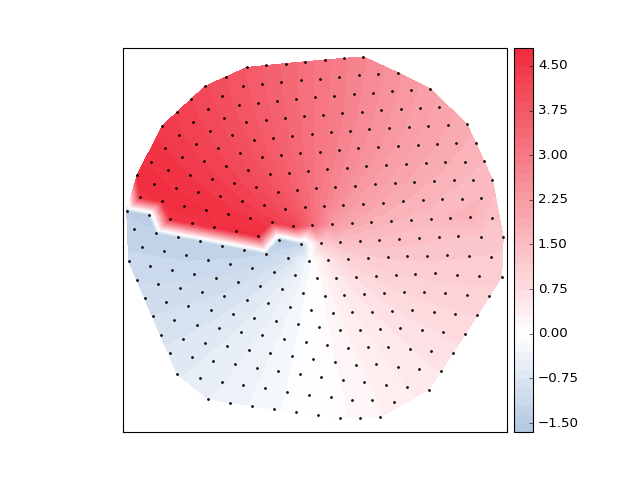

In [32]:
fig, ax = pyplot.subplots()

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = 15.0, lat_0=45.0, lat_ts=45.0,
                width=base.xmax, height=base.ymax, resolution="l")

base.colorbar(scha.polar_tricontour(D_r, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr))
base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

In [18]:
k, m, n = scha.join_roots(scha.degree(numpy.arange(0,2), theta_0, 1, overstep_size=0.1))

<IPython.core.display.Javascript object>


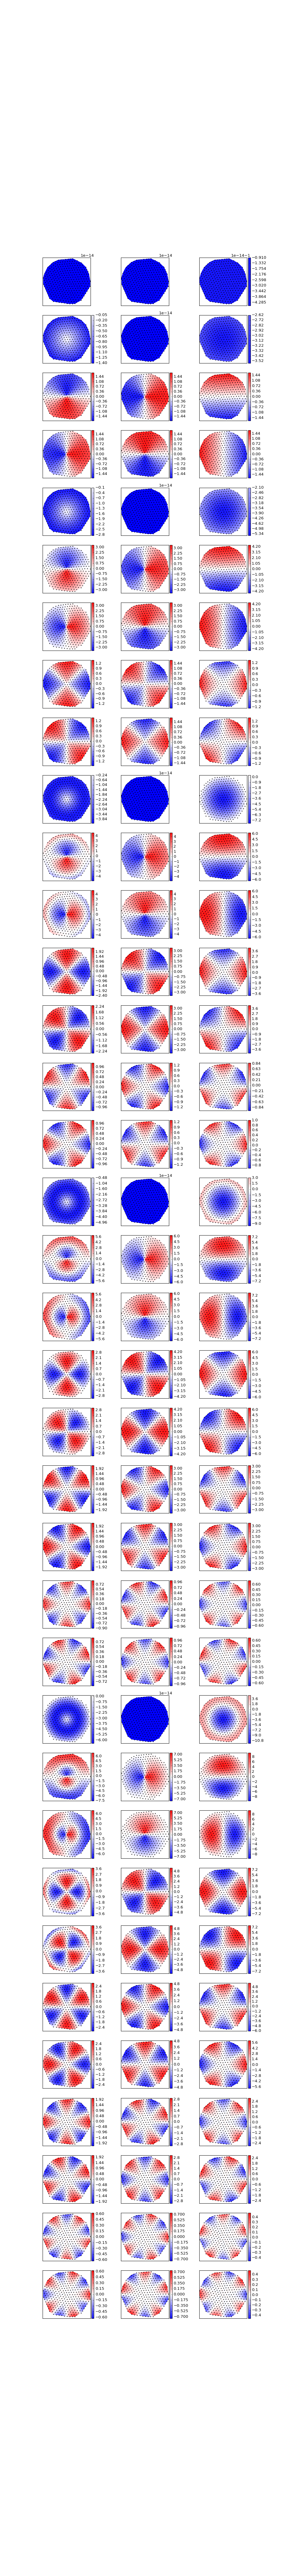

In [68]:
fig, axes = pyplot.subplots(len(k), 3, figsize=(12, 3*len(k)))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = 15.0, lat_0=45.0, lat_ts=45.0,
                width=base.xmax, height=base.ymax, resolution="l")

for i, (ki, mi, ni, ax) in enumerate(zip(k, m, n, axes)):
    gcoefs = numpy.zeros_like(k)
    gcoefs[i] = 1.0
    
    bx, by, bz = scha.xyzfield(k, m, n, gcoefs, theta_r, phi_r)
    for b, axi in zip((bx, by, bz), ax):
        base.colorbar(scha.polar_tricontour(b, theta_r, phi_r, theta_0, axi, base), ax=axi)
        base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=axi)

In [56]:
gp_javi = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/gh.dat")
bx_javi = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/output.dat", usecols=[13])

In [50]:
gp_javi.shape

(64,)

In [58]:
bx_javi-Bx_rr

array([ -7.62089334e+01,  -5.69931594e+01,  -4.40979205e+01,
        -2.09393778e+01,  -1.59773685e+01,  -2.35098324e+01,
        -2.89589998e+01,  -2.50657830e+01,  -2.31701278e+01,
         1.35252952e+01,   1.79660721e+01,   2.46914738e+01,
         4.43794539e+01,   3.64600989e+01,   3.70495586e+01,
         3.60349037e+01,   2.23755733e+01,   2.38864274e+00,
        -4.22674125e+00,   1.60859134e+01,   1.24574988e+01,
         9.00135150e+00,   3.56165800e+01,   1.78716248e+01,
         4.06239070e+01,   3.57364358e+01,   4.91564681e+01,
         2.83881411e+01,   4.31910255e+01,   1.91508809e+01,
         2.88606353e+00,  -7.08833544e+00,  -1.54199606e+01,
        -2.93153155e+01,   3.83017173e-01,   1.60465548e+01,
         3.35548242e+00,   2.41195424e+01,  -8.32378260e+00,
         5.07566505e+01,   2.01852598e+01,   6.24598908e+01,
         5.09248971e+01,   8.12741754e+00,   2.35120270e+01,
        -1.87284360e+00,  -1.11413742e+02,  -9.64998808e+00,
        -1.22027118e+01,

In [291]:
scha.dlpmv(0, 0, 0.4)

-0.0

In [292]:
gcoefs = numpy.zeros_like(k)
gcoefs[0] = 1.0

bx, by, bz = scha.xyzfield(k, m, n, gcoefs, theta_r, phi_r)

In [294]:
by

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0